### Shack-Hartmann wavefront sensing without a planar reference wavefront

The purpose of this notebook is to describe and demonstrate tentative methods for choosing SHWS reference coordinates without direct calibration using a referance planar wavefront. The goals of such methods are:

1. To alleviate the need for a separate reference channel in AO systems, and its alignment and maintenance.
2. To address the common issue of having tip and tilt error between measured reference coordinates and centroids of spots generated by an eye or model eye.

The proposed methods utilize a few readily available pieces of information:

1. The geometry of the lenslet array (viz., the lenslet pitch or center-to-center distance between lenslets), contained in `ciao_config.py`.
2. A sample spots image generated by beacon light backscattered from an eye or model eye, contained in `spots.txt`.
3. A reference mask that defines the logical locations of the active lenslets, contained in 'reference_mask.txt'.
4. The half-width of the desired search boxes, contained in `ciao_config.py`.
5. The size of the camera pixels, contained in `ciao_config.py`.

In [1]:
# standard imports
import numpy as np
from matplotlib import pyplot as plt
import sys,os

### Method 1: manual selection and automated fine tuning

In this approach, we define reference coordinates using the lenslet geometry and mask, and position those coordinates centered at a manually selected center of the spots image. Using those coordinates, we compute the tip and tilt, and use the computed tip and tilt to refine the coordinates in one step.

In [2]:
import ciao_config as ccfg
from ciao3.components.sensors import Sensor
from ciao3.components.mirrors import Mirror

if ccfg.simulate:
    from ciao3.components.simulator import Simulator

    sim = Simulator()
    sensor = Sensor(sim)
    mirror = sim
else:
    from ciao3.components import cameras
    cam = cameras.get_camera()
    mirror = Mirror()
    sensor = Sensor(cam)



No module named 'ximea'


In [3]:
mask = np.loadtxt('./etc/ref/reference_mask.txt')
sensor.sense()
spots = sensor.image

Sensor sense method
start -> cam.get_image: 59.354 ms
cam.get_image -> image stats: 3.990 ms
image stats -> estimate background: 0.997 ms
estimate background -> centroid: 15.956 ms
centroid -> reconstruct wavefront: 0.000 ms
reconstruct wavefront -> end sense: 0.000 ms

1


In [4]:
pixel_size_m = ccfg.pixel_size_m
search_box_half_width = ccfg.search_box_half_width
lenslet_pitch_m = ccfg.lenslet_pitch_m
print(search_box_half_width)
print(lenslet_pitch_m)
print(pixel_size_m)

# now determine the logical dimensions of the lenslet array,
# i.e. the number of lenslets in each dimension
mask_sy,mask_sx = mask.shape

# now the size of the spots image
spots_sy,spots_sx = spots.shape

print(mask.shape)
print(spots.shape)

25
0.0003
5.5e-06
(29, 29)
(2048, 2048)


In [5]:
# Begin by defining a SearchBox class that represents a
# single search box, defined by its x and y coordinates and
# its half-width.
# This is based on our SearchBox class from last week. The only
# difference is that we define it in terms of half-width so we can
# guarantee that its width (2*half_width+1) is odd and it has a
# center pixel. Not sure if that's important.
class SearchBox:
    def __init__(self,x,y,half_width):
        self.width = half_width*2+1
        width = self.width
        self.x = x
        self.y = y
        self.x1 = int(np.floor(x-width/2.0))
        self.x2 = int(np.floor(x+width/2.0))
        self.y1 = int(np.floor(y-width/2.0))
        self.y2 = int(np.floor(y+width/2.0))
        self.XX,self.YY = np.meshgrid(np.arange(width),np.arange(width))
        # XX and YY are the 2D coordinate system for this
        # search box; let's zero-center these, so that the
        # centers of mass returned by centroid below correspond
        # to absolute spot displacements
        self.XX = self.XX - half_width
        self.YY = self.YY - half_width
        #print(self.x1,self.x2,self.y1,self.y2)
        
    def get_roi(self,im):
        return im[self.y1:self.y2,self.x1:self.x2]
    
    def draw(self,ax=None,full_image=True,border=5):
        if ax is None:
            ax = plt.gca()
        plt.plot([self.x1,self.x2,self.x2,self.x1,self.x1],
                 [self.y1,self.y1,self.y2,self.y2,self.y1],'y')
        if not full_image:
            plt.xlim((self.x1-border,self.x2+border))
            plt.ylim((self.y1-border,self.y2+border))
            
    def estimate_background(self,im):
        roi = self.get_roi(im)
        bg = []
        for dx in range(self.width):
            bg.append(roi[0,dx])
            bg.append(roi[-1,dx])
        for dy in range(self.width):
            bg.append(roi[dy,0])
            bg.append(roi[dy,-1])
        return np.mean(bg)
    
    def centroid(self,im):
        roi = self.get_roi(im)
        roi = roi - self.estimate_background(im)
        
        xcom = np.sum(roi*self.XX)/np.sum(roi)
        ycom = np.sum(roi*self.YY)/np.sum(roi)
        return xcom,ycom
    
    def intensity(self,im):
        roi = self.get_roi(im)
        return np.sum(roi)

# now define a function that generates a set of search boxes
# centered about a point (dx_px,dy_px) in pixel coordinates:

def make_boxes(dx_px,dy_px):
    search_boxes = []

    index = 0
    # iterate through the mask and add a search box wherever the
    # mask is 1
    for y in range(mask_sy):
        for x in range(mask_sx):
            if mask[y,x]:
                y_m = (y-mask_sy/2)*lenslet_pitch_m
                y_px = y_m/pixel_size_m+dy_px
                x_m = (x-mask_sx/2)*lenslet_pitch_m
                x_px = x_m/pixel_size_m+dx_px
                sb = SearchBox(x_px,y_px,search_box_half_width)
                # we need a degenerate condition in case the search
                # boxes extend past the edges of the image; the
                # cost function will give a very high cost if this
                # function returns np.inf
                if sb.x1<0 or sb.y1<0 or sb.x2>=spots_sx or sb.y2>=spots_sy:
                    print('Search box %d failed (x: %0.1f,%0.1f; y: %0.1f,%0.1f)'%(index,sb.x1,sb.x2,sb.y1,sb.y2))
                    return None
                search_boxes.append(sb)
                index = index + 1
    return search_boxes

In [6]:
# a decent guess at the search box origin is x=1040,y=1024, which gets the spots
# roughly centered in the boxes:
ref_origin_x_guess = 1049
ref_origin_y_guess = 1024
search_boxes_guess = make_boxes(ref_origin_x_guess,ref_origin_y_guess)

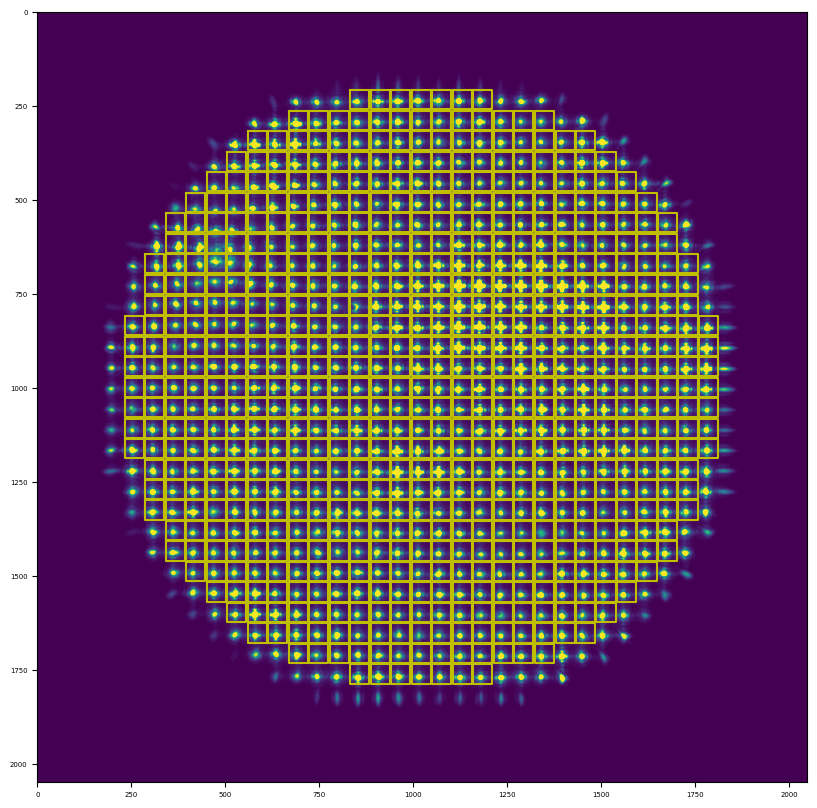

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(spots,clim=(50,1000))
for box in search_boxes_guess:
    box.draw()
plt.show()

-7.921072957482012 8.634206858854157
1041.078927042518 1032.6342068588542
[ 1.61611193 -1.78135427]


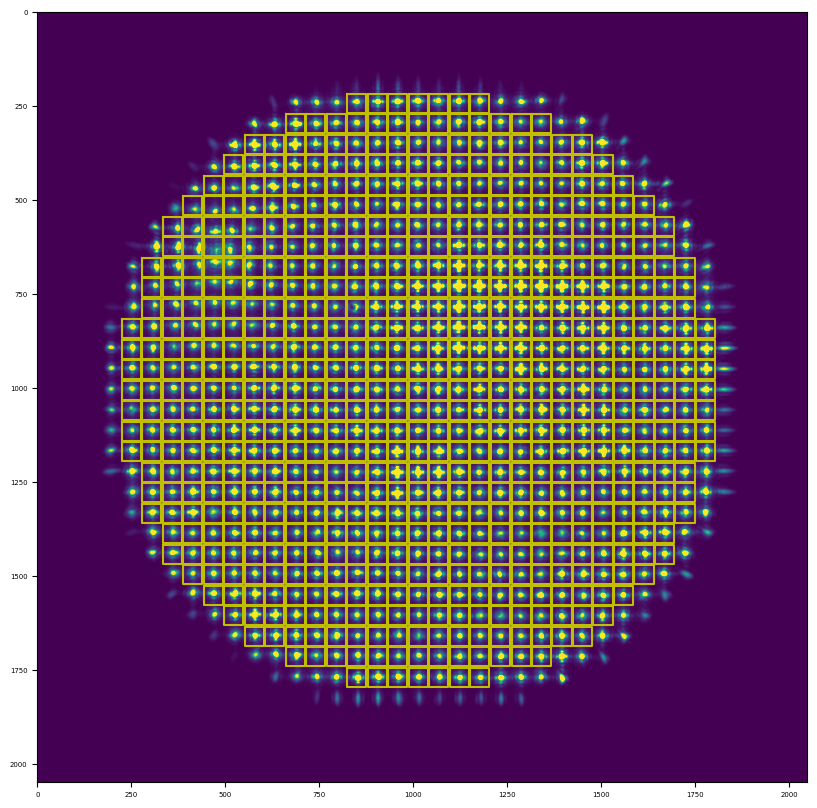

In [8]:
# now we compute the tip and tilt by averaging the x and y centroids, which
# are returned relative to the reference coordinates
centroids = [sb.centroid(spots) for sb in search_boxes_guess]
x_centroids = [c[0] for c in centroids]
y_centroids = [c[1] for c in centroids]
tilt = np.mean(x_centroids)
tip = np.mean(y_centroids)
print(tilt,tip)
ref_origin_x = ref_origin_x_guess+tilt
ref_origin_y = ref_origin_y_guess+tip
print(ref_origin_x,ref_origin_y)
search_boxes = make_boxes(ref_origin_x,ref_origin_y)

# verify that tip and tilt are now close to zero
# note that they will not be zero exactly because of noise and
# rounding of the search box edge coordinates to whole pixels
test = np.array([sb.centroid(spots) for sb in search_boxes])
print(np.mean(test,axis=0))

plt.figure(figsize=(10,10))
plt.imshow(spots,clim=(50,1000))
for box in search_boxes:
    box.draw()
plt.show()

In [11]:
x_ref = [sb.x for sb in search_boxes]
y_ref = [sb.y for sb in search_boxes]
reference = np.array(list(zip(x_ref,y_ref)))
print(reference)

[[ 850.16983613  241.72511595]
 [ 904.71529068  241.72511595]
 [ 959.26074522  241.72511595]
 ...
 [1068.35165432 1768.99784322]
 [1122.89710886 1768.99784322]
 [1177.44256341 1768.99784322]]


In [12]:
np.savetxt(ccfg.reference_coordinates_filename,reference)